In [20]:
import warnings
warnings.filterwarnings("ignore")

import os.path
import ssm
import pickle
import numpy as np
import pandas as pd
import scipy
import copy
from tqdm import tqdm

from runwise_ts_log_data import get_ts_log_data_blocked

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns

from sympy.utilities.iterables import multiset_permutations
from ssm.util import *
from scipy.stats import ttest_ind

In [21]:
with open('pkl/emoprox2_dataset_timeseries+inputs_MAX85.pkl','rb') as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df['pid'].unique())
subj_list = subj_list[:] # remove first 30 subjects
orig_df = orig_df[orig_df['pid'].isin(subj_list)]

In [22]:
subj_list[30:]

['031',
 '032',
 '033',
 '034',
 '035',
 '036',
 '037',
 '038',
 '039',
 '040',
 '041',
 '042',
 '043',
 '044',
 '045',
 '046',
 '047',
 '048',
 '049',
 '050',
 '051',
 '052',
 '053',
 '054',
 '055',
 '056',
 '057',
 '058',
 '059',
 '060',
 '061',
 '062',
 '063',
 '064',
 '065',
 '066',
 '067',
 '068',
 '069',
 '071',
 '072',
 '073',
 '074',
 '075',
 '076',
 '077',
 '078',
 '079',
 '080',
 '081',
 '082',
 '083',
 '084',
 '085',
 '086',
 '087',
 '088',
 '089',
 '090',
 '091',
 '092',
 '093',
 '094',
 '095',
 '096',
 '097',
 '098',
 '099',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '125']

In [23]:
K = 6
D = 10
N = 85
num_subjs = 92
num_resamples = 100

In [24]:
with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{122}subjs_1.pkl','rb') as f:
        model1,q1,elbos1,resampled_subj_list = pickle.load(f)

resampled_df = []
for pid in resampled_subj_list:
    resampled_df.append(orig_df[orig_df['pid']==pid])
resampled_df = pd.concat(resampled_df).reset_index().drop('index',axis=1)

df1 = resampled_df

df1['continuous_states'] = [None]*df1.shape[0]
df1['discrete_states'] =[None]*df1.shape[0]
hrflag=0
prox_bins = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
dir_bins = [0]
nprox = len(prox_bins)+1
ndir = len(dir_bins)+1
for idx_row in range(df1.shape[0]):
    prox = df1.loc[idx_row]['proximity']
    prox = prox - prox.min()
    prox = prox / prox.max()
    proxd = np.digitize(prox, bins=prox_bins)
    dird = 1-np.digitize(df1.loc[idx_row]['direction'], bins=dir_bins)
    stim_category = (nprox*ndir-1)*dird+((-1)**dird)*proxd
    input = np.roll(np.eye(nprox*ndir)[stim_category],shift=hrflag,axis=0)

    y = df1.loc[idx_row]['timeseries']
    x = q1.mean_continuous_states[idx_row]
    z = model1.most_likely_states(x,y,input=input)
    df1.at[idx_row,'continuous_states'] = x
    df1.at[idx_row,'discrete_states'] = z
    prox = df1.loc[idx_row]['proximity']
    prox = prox - prox.min()
    prox = prox / prox.max()
    df1.at[idx_row,'proximity'] = prox

(144, 2) (144,)


Text(0, 0.5, 'PC2')

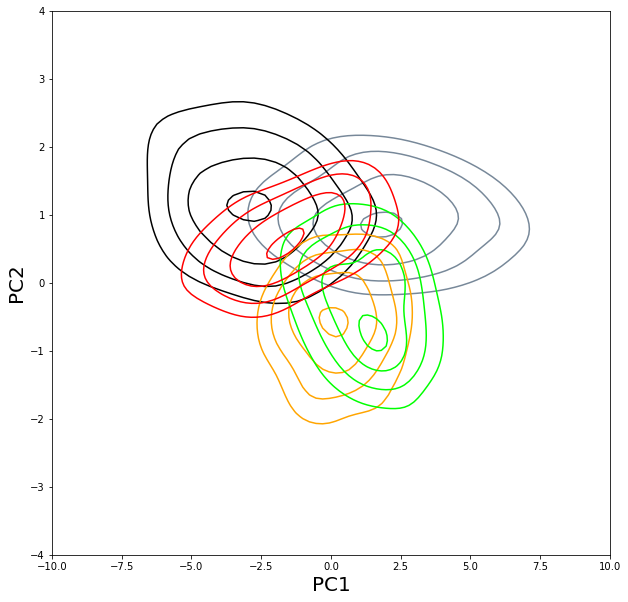

In [25]:
from pyparsing import col
from sklearn.decomposition import PCA
all_x = np.vstack(list(df1['continuous_states'].values))
all_z = np.hstack(list(df1['discrete_states'].values))+1
pca = PCA(n_components=2)
pca.fit(all_x)
x2d = pca.transform(all_x)
state_names = ['post-shock','shock','far','retreat','???','near']
statespace_df = pd.DataFrame({'pc1':x2d[:,0],'pc2':x2d[:,1],'z':all_z})
statespace_df = statespace_df[statespace_df['z'].isin([1,2,3,4,6])]

df2 = df1[(df1['rid']==0)&(df1['block']==1)]
mean_x = np.mean(np.stack([x[:144,:] for x in list(df2['continuous_states'].values)],axis=0),axis=0)
mean_x2d = pca.transform(mean_x)
from scipy.stats import mode
mode_z = mode(np.stack([z[:144] for z in list(df2['discrete_states'].values)],axis=0),axis=0).mode.flatten()

from matplotlib.collections import LineCollection


print(mean_x2d.shape,mode_z.shape)

from matplotlib.colors import ListedColormap,to_rgba
col_dict = {1: "lightslategray",
            2: "black",
            3: "orange",
            4: "lime",
            6: "red"}
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])



# import cmasher as cmr
# cm = cmr.neon_r

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
sns.kdeplot(
    data=statespace_df, 
    x="pc1", y="pc2", 
    hue="z", 
    levels=np.array([0.7,0.8,0.9,0.99]),
    palette=cm,
    common_norm=False,
    legend=False
)

x1 = mean_x2d[:,0]
x2 = mean_x2d[:,1]

# segs = []
# colors = []
# for t in range(x1.shape[0]-1):
#     segs.append([(x1[t],x2[t]),(x1[t+1],x2[t+1])])
#     colors.append(to_rgba(col_dict[mode_z[t]+1]))
# print(len(colors),len(segs))

# line_segments = LineCollection(
#     segs,
#     colors=colors,
#     linewidths=[1]*143,
#     linestyles='solid',
# )
# ax.add_collection(line_segments)


ax.set_xlim([-10,10])
ax.set_ylim([-4,4])
ax.set_xlabel("PC1",fontsize=20)
ax.set_ylabel("PC2",fontsize=20)
# fig.savefig(f'figures/fig_attractor_basins_K{K}.jpeg',dpi=600,bbox_inches='tight')

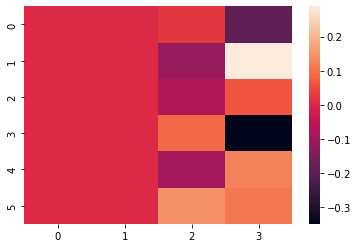

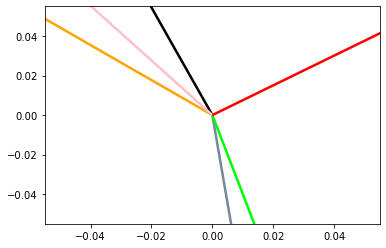

In [26]:
Rs = model1.transitions.Rs
Rs2d = pca.transform(Rs)
Rs2d = np.hstack([np.zeros_like(Rs2d),-Rs2d])
sns.heatmap(Rs2d)
X, Y, U, V = zip(*Rs2d)
plt.figure()
ax = plt.gca()
ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1, color=["lightslategray","black","orange","lime","pink","red"])